In [10]:
import pandas as pd
import json
import numpy as np
import operator
import matplotlib.pyplot as plt
from collections import Counter
import os
import time
import pickle
import networkx as nx
import string

pd.options.mode.chained_assignment = None  # default='warn'

ROOT = os.path.dirname(os.getcwd())
teams = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'teams.pkl.gz'))
players = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'players.pkl.gz'))
players['shortName'] = players['shortName'].apply(lambda s: ''.join([x for x in s if x.isalpha() or x in [' ', '.'] ]))
player_mapping = {row['wyId'] : row['shortName'] for i, row in players.iterrows()}
players

,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,wyId,foot,shortName,...,passportArea.id,passportArea.alpha3code,passportArea.alpha2code,role.code2,role.code3,role.name,birthArea.name,birthArea.id,birthArea.alpha3code,birthArea.alpha2code
0,78,Harun,,Tekin,4502,1989-06-17,187,32777,right,H. Tekin,...,792,TUR,TR,GK,GKP,Goalkeeper,Turkey,792,TUR,TR
1,73,Malang,,Sarr,3775,1999-01-23,182,393228,left,M. Sarr,...,686,SEN,SN,DF,DEF,Defender,France,250,FRA,FR
2,72,Over,,Mandanda,3772,1998-10-26,176,393230,,O. Mandanda,...,250,FRA,FR,GK,GKP,Goalkeeper,France,250,FRA,FR
3,82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,32793,right,A. NDiaye,...,686,SEN,SN,MD,MID,Midfielder,France,250,FRA,FR
4,84,Ibrahima,,Konat\u00e9,2975,1999-05-25,192,393247,right,I. Konatue,...,250,FRA,FR,DF,DEF,Defender,France,250,FRA,FR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598,72,Ali,,Ma\u00e2loul,16041,1990-01-01,175,120839,left,A. Maueloul,...,788,TUN,TN,DF,DEF,Defender,Tunisia,788,TUN,TN
3599,76,Carlos Alberto,,C\u00e1ceda Oyaguez,15591,1991-09-27,183,114736,right,C. Cueceda,...,604,PER,PE,GK,GKP,Goalkeeper,Peru,604,PER,PE
3600,78,Miguel Gianpierre,,Araujo Blanco,12072,1994-10-24,179,114908,right,M. Araujo,...,604,PER,PE,DF,DEF,Defender,Peru,604,PER,PE
3601,70,Ahmed Reda,,Tagnaouti,16183,1996-04-05,182,285583,right,A. Tagnaouti,...,504,MAR,MA,GK,GKP,Goalkeeper,Morocco,504,MAR,MA


### Possesion
Proxying it by pass proportion

In [11]:
events = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'events_df.pkl.gz'))
events_passing = events.loc[events['eventName']=='Pass']
possession = events_passing.groupby(['matchId', 'teamId']).count().mean(axis=1).to_frame('possession').sort_index()
normalization_factor = possession.groupby(possession.index.get_level_values(0)).transform(sum)
possession = possession/normalization_factor
possession

possession
matchId teamId            
2499719 1609      0.724880
        1631      0.275120
2499720 1625      0.803838
        1651      0.196162
2499721 1610      0.635468
...                    ...
2576336 3315      0.402628
2576337 3164      0.551298
        3204      0.448702
2576338 3185      0.388506
        3193      0.611494

[3652 rows x 1 columns]

### Defensive duels
Counting duels won, lost, neutral. Skipping Ground Offensize Duels

In [12]:
defensive_duels = events.loc[(events['eventName']=='Duel') 
                            &(events['subEventName'].isin(['Ground defending duel', 'Ground loose ball duel', 'Air duel']))]
defensive_duels['tags'] = defensive_duels['tags'].apply(lambda l: [x['id'] for x in l])
defensive_duels['duels_lost'] = defensive_duels['tags'].apply(lambda l: 1 if 701 in l else 0)
defensive_duels['duels_neutral'] = defensive_duels['tags'].apply(lambda l: 1 if 702 in l else 0)
defensive_duels['duels_won'] = defensive_duels['tags'].apply(lambda l: 1 if 703 in l else 0)
defensive_duels

eventId            subEventName                         tags  \
Italy 7             1   Ground defending duel             [504, 701, 1802]   
      8             1   Ground defending duel             [601, 701, 1802]   
      12            1  Ground loose ball duel                  [703, 1801]   
      13            1  Ground loose ball duel                  [701, 1802]   
      19            1   Ground defending duel             [504, 701, 1802]   
...               ...                     ...                          ...   
Spain 628620        1   Ground defending duel             [504, 702, 1801]   
      628629        1   Ground defending duel  [504, 1601, 601, 701, 1802]   
      628643        1   Ground defending duel                  [701, 1802]   
      628645        1   Ground defending duel                  [703, 1801]   
      628646        1   Ground defending duel                  [701, 1802]   

              playerId                                 positions  matchId  \
Italy 7          86366  [{'y': 85, 'x': 36}, {'y': 75, 'x': 28}]  2575959   
      8          20404  [{'y': 75, 'x': 28}, {'y': 36, 'x': 18}]  2575959   
      12          8306  [{'y': 12, 'x': 61}, {'y': 15, 'x': 61}]  2575959   
      13        246175  [{'y': 88, 'x': 39}, {'y': 85, 'x': 39}]  2575959   
      19         20404  [{'y': 90, 'x': 49}, {'y': 87, 'x': 35}]  2575959   
...                ...                                       ...      ...   
Spain 628620      3310    [{'y': 7, 'x': 58}, {'y': 0, 'x': 54}]  2565927   
      628629    286994   [{'y': 5, 'x': 36}, {'y': 11, 'x': 36}]  2565927   
      628643      4498  [{'y': 96, 'x': 60}, {'y': 95, 'x': 58}]  2565927   
      628645     69404  [{'y': 95, 'x': 58}, {'y': 93, 'x': 51}]  2565927   
      628646    122832    [{'y': 7, 'x': 49}, {'y': 5, 'x': 47}]  2565927   

             eventName  teamId matchPeriod     eventSec subEventId         id  \
Italy 7           Duel    3172          1H    11.527556         12  180423976   
      8           Duel    3172          1H    12.156579         12  180423977   
      12          Duel    3158          1H    17.715422         13  180423967   
      13          Duel    3172          1H    17.791970         13  180423983   
      19          Duel    3172          1H    26.752540         12  180423984   
...                ...     ...         ...          ...        ...        ...   
Spain 628620      Duel     675          2H  2793.229781         12  253302666   
      628629      Duel     682          2H  2826.155800         12  253302636   
      628643      Duel     675          2H  2880.551604         12  253302688   
      628645      Duel     675          2H  2881.224312         12  253302689   
      628646      Duel     682          2H  2882.558967         12  253302657   

              duels_lost  duels_neutral  duels_won  
Italy 7                1              0          0  
      8                1              0          0  
      12               0              0          1  
      13               1              0          0  
      19               1              0          0  
...                  ...            ...        ...  
Spain 628620           0              1          0  
      628629           1              0          0  
      628643           1              0          0  
      628645           0              0          1  
      628646           1              0          0  

[566599 rows x 15 columns]

In [13]:
def_duel_counts = defensive_duels.groupby(by=['matchId', 'teamId'])[['duels_lost', 'duels_neutral', 'duels_won']].sum()
def_duel_counts 

duels_lost  duels_neutral  duels_won
matchId teamId                                      
2499719 1609            68             44         62
        1631            94             44         53
2499720 1625            49             24         42
        1651            70             24         38
2499721 1610            72             18         54
...                    ...            ...        ...
2576336 3315            74             32         43
2576337 3164            62             21         44
        3204            77             26         49
2576338 3185            73             31         50
        3193            61             29         45

[3652 rows x 3 columns]

### Fouls


In [14]:
fouls = events.loc[(events['eventName']=='Foul')]
fouls['tags'] = fouls['tags'].apply(lambda l: [x['id'] for x in l])
fouls['yellow_card'] = fouls['tags'].apply(lambda l: 1 if 1702 in l else 0)
fouls['second_yellow_card'] = fouls['tags'].apply(lambda l: 1 if 1703 in l else 0)
fouls['red_card'] = fouls['tags'].apply(lambda l: 1 if 1701 in l else 0)
fouls['total_fouls'] = 1
foul_counts = fouls.groupby(by=['matchId', 'teamId'])[['yellow_card', 'second_yellow_card', 'total_fouls']].sum()
foul_counts

yellow_card  second_yellow_card  total_fouls
matchId teamId                                              
2499719 1609              0                   0            9
        1631              1                   0           12
2499720 1625              2                   0            9
        1651              0                   0            6
2499721 1610              4                   1           18
...                     ...                 ...          ...
2576336 3315              1                   0           14
2576337 3164              3                   1           13
        3204              1                   0           10
2576338 3185              2                   1           11
        3193              1                   0           10

[3652 rows x 3 columns]

### More Special Events

In [15]:
events2 = events.copy()
events2['tags'] = events2['tags'].apply(lambda l: [x['id'] for x in l])
events2['dangerous_ball_lost'] = [True if 2001 in x else False for x in events2['tags']]
events2['interception_total'] = [True if 1401 in x else False for x in events2['tags']]
events2['interception_inside_box'] = np.array([True if x[0]['y']<75 and x[0]['y']>25 and x[0]['x']<20 else False for x in events2['positions']]) & \
                                        np.array([True if 1401 in x else False for x in events2['tags']])
events2['sliding_tackle_total'] = [True if 1601 in x else False for x in events2['tags']]
events2['sliding_tackle_inside_box'] = np.array([True if x[0]['y']<75 and x[0]['y']>25 and x[0]['x']<20 else False for x in events2['positions']]) & \
                                        np.array([True if 1601 in x else False for x in events2['tags']])
events2 = events2.groupby(by=['matchId', 'teamId'])[['dangerous_ball_lost', 'interception_total', 'interception_inside_box', 'sliding_tackle_total', 'sliding_tackle_inside_box']].sum()
events2

dangerous_ball_lost  interception_total  \
matchId teamId                                            
2499719 1609                      4                  40   
        1631                      4                  56   
2499720 1625                      1                  30   
        1651                      3                  54   
2499721 1610                      0                  27   
...                             ...                 ...   
2576336 3315                      2                  44   
2576337 3164                      0                  21   
        3204                      0                  35   
2576338 3185                      3                  41   
        3193                      1                  21   

                interception_inside_box  sliding_tackle_total  \
matchId teamId                                                  
2499719 1609                          7                     2   
        1631                         23                     7   
2499720 1625                          3                     3   
        1651                         22                     5   
2499721 1610                          5                    10   
...                                 ...                   ...   
2576336 3315                         21                     6   
2576337 3164                          9                     2   
        3204                         10                     7   
2576338 3185                         15                     5   
        3193                          4                     4   

                sliding_tackle_inside_box  
matchId teamId                             
2499719 1609                            0  
        1631                            0  
2499720 1625                            0  
        1651                            1  
2499721 1610                            0  
...                                   ...  
2576336 3315                            0  
2576337 3164                            0  
        3204                            0  
2576338 3185                            1  
        3193                            0  

[3652 rows x 5 columns]

### Putting it all together

In [16]:
master = pd.concat([possession, def_duel_counts, foul_counts, events2], axis=1)
performance = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))

tmp = pd.concat([master.mean(level=1), performance], axis=1)
errors = master.groupby(master.index.get_level_values(1)).sem()
tmp

,possession,duels_lost,duels_neutral,duels_won,yellow_card,second_yellow_card,total_fouls,dangerous_ball_lost,interception_total,interception_inside_box,sliding_tackle_total,sliding_tackle_inside_box,name,city,area.name,avg_pass_per_game,avg_shots_per_game,avg_goals_per_game,end_of_season_pts
674,0.485533,70.052632,29.315789,48.289474,2.684211,0.105263,14.052632,1.210526,44.605263,16.473684,7.105263,0.473684,Valencia,Valencia,Spain,413.789474,11.000000,1.421053,73
675,0.610870,57.131579,27.631579,43.447368,1.684211,0.052632,11.763158,1.368421,36.447368,11.131579,4.210526,0.184211,Real Madrid,Madrid,Spain,581.078947,16.605263,2.131579,76
676,0.637860,52.447368,22.789474,38.789474,1.763158,0.000000,10.500000,1.657895,39.447368,12.026316,4.868421,0.263158,Barcelona,Barcelona,Spain,612.105263,13.210526,2.289474,93
677,0.464069,73.315789,29.842105,49.894737,2.631579,0.026316,13.973684,1.342105,46.394737,16.342105,6.763158,0.684211,Deportivo La Coru\u00f1a,A Coru\u00f1a,Spain,382.605263,10.657895,0.921053,29
678,0.494226,75.657895,31.631579,56.710526,2.421053,0.000000,14.315789,1.368421,46.052632,14.105263,5.868421,0.578947,Athletic Club,Bilbao,Spain,395.315789,9.921053,0.842105,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,0.418782,76.473684,32.447368,49.105263,2.000000,0.052632,13.421053,0.763158,46.605263,16.447368,5.263158,0.526316,Troyes,Troyes,France,360.605263,8.578947,0.710526,33
3799,0.443816,73.315789,31.315789,48.500000,1.815789,0.052632,13.052632,0.657895,43.526316,13.526316,4.157895,0.421053,Angers,Angers,France,379.105263,10.736842,0.947368,43
3804,0.483672,76.000000,34.342105,52.236842,1.789474,0.026316,13.236842,1.500000,46.210526,15.921053,6.657895,0.289474,Dijon,Dijon,France,390.131579,10.368421,1.236842,46
10531,0.445552,70.657895,32.315789,49.947368,1.342105,0.000000,10.368421,0.868421,45.394737,16.894737,5.552632,0.605263,Swansea City,Swansea,England,390.578947,8.000000,0.684211,33


#### Analysis: Goals/Game

,duels_lost,avg_goals_per_game
duels_lost,1.000000,-0.694223
avg_goals_per_game,-0.694223,1.000000


<Figure size 1080x360 with 0 Axes>

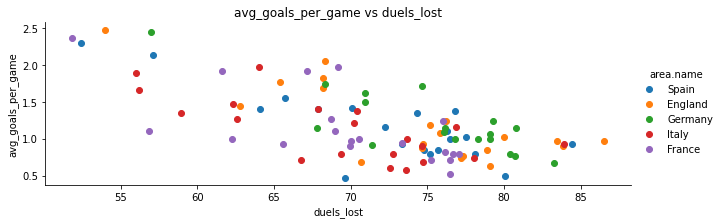

,duels_neutral,avg_goals_per_game
duels_neutral,1.000000,-0.520394
avg_goals_per_game,-0.520394,1.000000


<Figure size 1080x360 with 0 Axes>

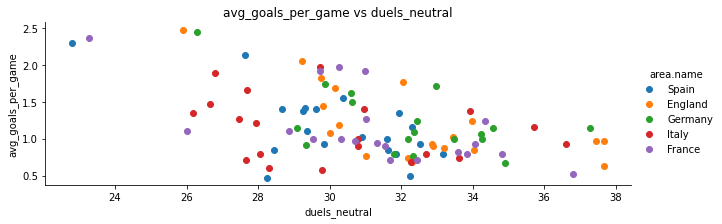

,duels_won,avg_goals_per_game
duels_won,1.000000,-0.466348
avg_goals_per_game,-0.466348,1.000000


<Figure size 1080x360 with 0 Axes>

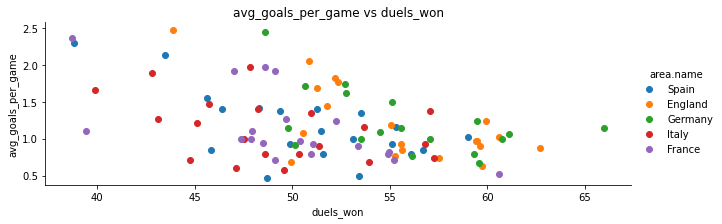

,yellow_card,avg_goals_per_game
yellow_card,1.000000,-0.315891
avg_goals_per_game,-0.315891,1.000000


<Figure size 1080x360 with 0 Axes>

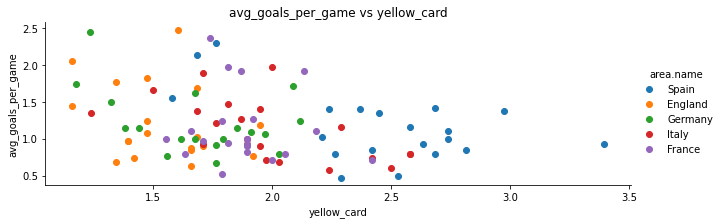

,second_yellow_card,avg_goals_per_game
second_yellow_card,1.000000,-0.150831
avg_goals_per_game,-0.150831,1.000000


<Figure size 1080x360 with 0 Axes>

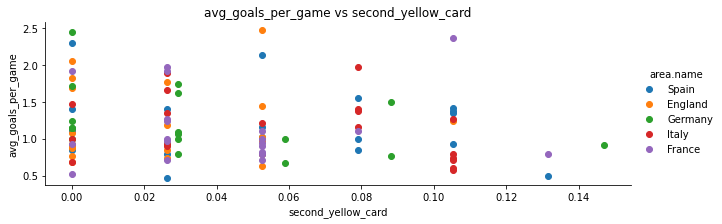

,total_fouls,avg_goals_per_game
total_fouls,1.000000,-0.375939
avg_goals_per_game,-0.375939,1.000000


<Figure size 1080x360 with 0 Axes>

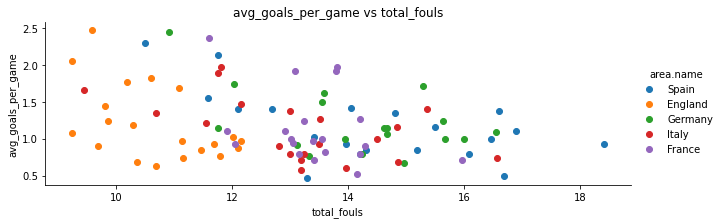

,dangerous_ball_lost,avg_goals_per_game
dangerous_ball_lost,1.000000,0.195673
avg_goals_per_game,0.195673,1.000000


<Figure size 1080x360 with 0 Axes>

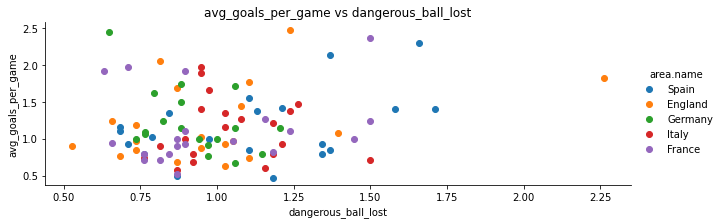

,interception_total,avg_goals_per_game
interception_total,1.000000,-0.647509
avg_goals_per_game,-0.647509,1.000000


<Figure size 1080x360 with 0 Axes>

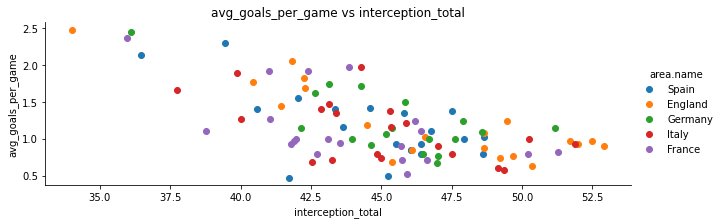

,interception_inside_box,avg_goals_per_game
interception_inside_box,1.000000,-0.633199
avg_goals_per_game,-0.633199,1.000000


<Figure size 1080x360 with 0 Axes>

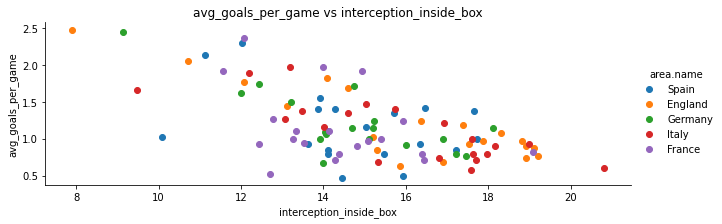

,sliding_tackle_total,avg_goals_per_game
sliding_tackle_total,1.000000,-0.247938
avg_goals_per_game,-0.247938,1.000000


<Figure size 1080x360 with 0 Axes>

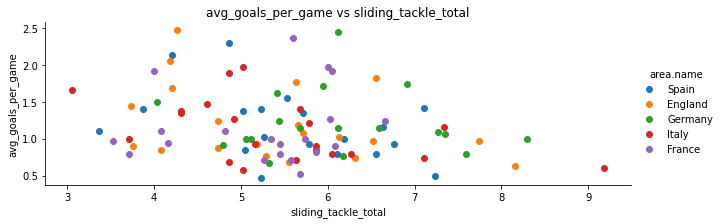

,sliding_tackle_inside_box,avg_goals_per_game
sliding_tackle_inside_box,1.000000,-0.360925
avg_goals_per_game,-0.360925,1.000000


<Figure size 1080x360 with 0 Axes>

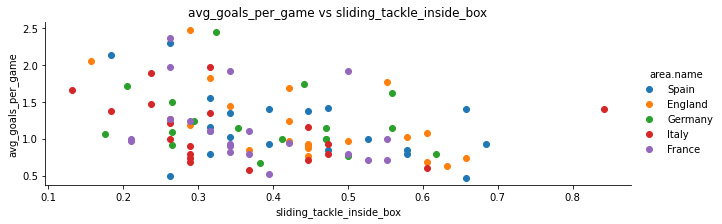

In [17]:
import seaborn
from matplotlib import pyplot 
#from ggplot import *

for metric in ['duels_lost',
               'duels_neutral',
               'duels_won',
               'yellow_card',
               'second_yellow_card',
               'total_fouls',
               'dangerous_ball_lost',
               'interception_total',
               'interception_inside_box',
               'sliding_tackle_total',
               'sliding_tackle_inside_box']:

    display(tmp[[metric, 'avg_goals_per_game']].corr())

    plt.figure(figsize=(15, 5))
    fg = seaborn.FacetGrid(data=tmp, hue='area.name', hue_order=tmp['area.name'].unique(), aspect=3)
    fg.map(pyplot.scatter, metric, 'avg_goals_per_game').add_legend()
    plt.title('avg_goals_per_game vs {}'.format(metric))
    #plt.text(.3, 0.5,'$\\rho$=0.52', fontsize=18)
    #plt.savefig('../figures/player_network_alg/clustering_coefficient_performance_EOS_pts', bbox_inches='tight')
    plt.show()

    #plt.figure()
    #tmp[[metric, 'end_of_season_pts']].plot(kind='scatter', x='end_of_season_pts', y=metric, yerr=errors[[metric]], figsize=(15, 5))
    #plt.title('End Of Season Points vs {} with Error Bars'.format(metric.upper()))
    #plt.savefig('../figures/player_network_alg/clustering_coefficient_performance_EOS_pts_ERROR', bbox_inches='tight')

    #plt.show()

#### Analysis : EOS Points

,duels_lost,end_of_season_pts
duels_lost,1.000000,-0.687175
end_of_season_pts,-0.687175,1.000000


<Figure size 1080x360 with 0 Axes>

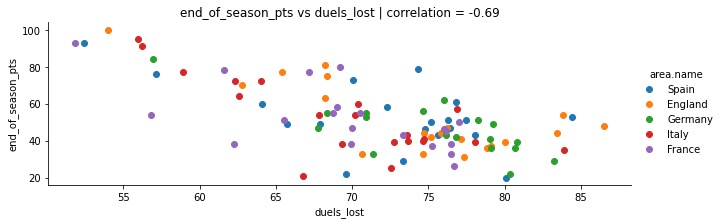

,duels_neutral,end_of_season_pts
duels_neutral,1.000000,-0.517643
end_of_season_pts,-0.517643,1.000000


<Figure size 1080x360 with 0 Axes>

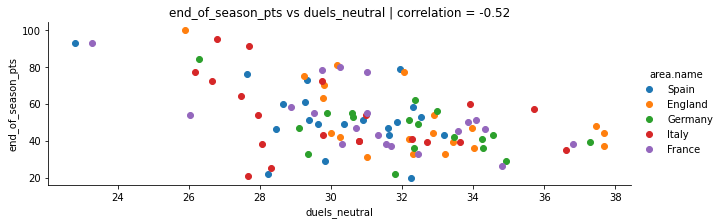

,duels_won,end_of_season_pts
duels_won,1.000000,-0.493379
end_of_season_pts,-0.493379,1.000000


<Figure size 1080x360 with 0 Axes>

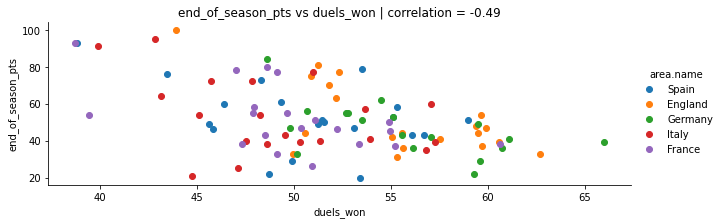

,yellow_card,end_of_season_pts
yellow_card,1.00000,-0.21014
end_of_season_pts,-0.21014,1.00000


<Figure size 1080x360 with 0 Axes>

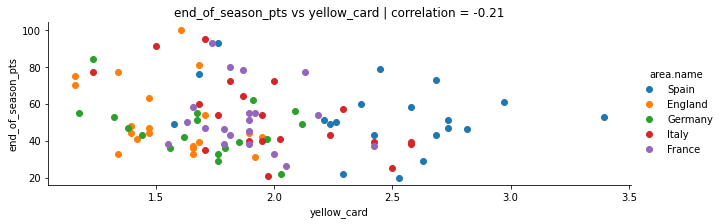

,second_yellow_card,end_of_season_pts
second_yellow_card,1.000000,-0.085699
end_of_season_pts,-0.085699,1.000000


<Figure size 1080x360 with 0 Axes>

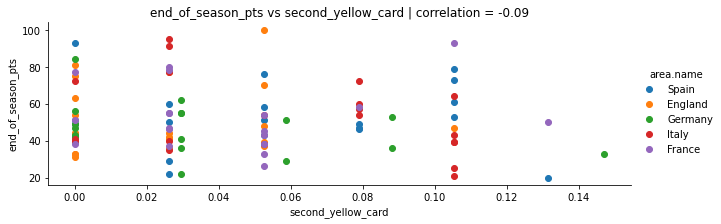

,total_fouls,end_of_season_pts
total_fouls,1.000000,-0.342855
end_of_season_pts,-0.342855,1.000000


<Figure size 1080x360 with 0 Axes>

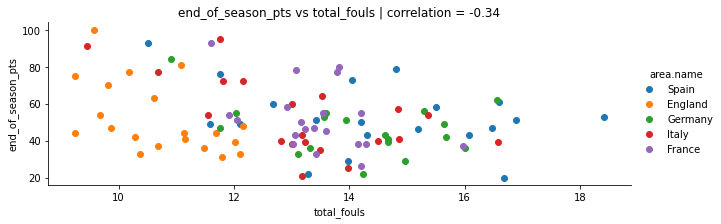

,dangerous_ball_lost,end_of_season_pts
dangerous_ball_lost,1.000000,0.098205
end_of_season_pts,0.098205,1.000000


<Figure size 1080x360 with 0 Axes>

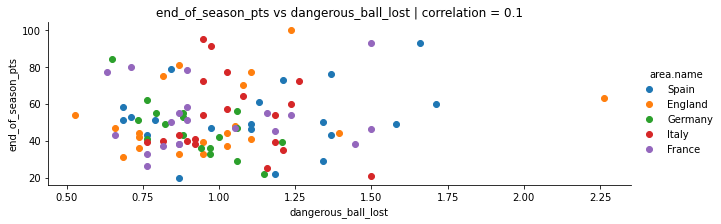

,interception_total,end_of_season_pts
interception_total,1.000000,-0.583712
end_of_season_pts,-0.583712,1.000000


<Figure size 1080x360 with 0 Axes>

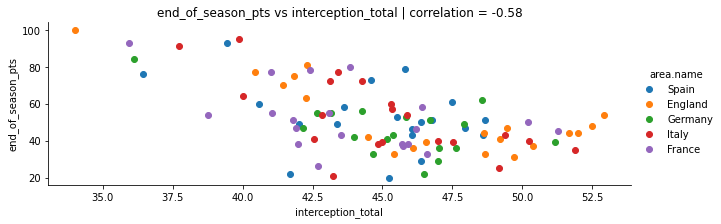

,interception_inside_box,end_of_season_pts
interception_inside_box,1.000000,-0.610831
end_of_season_pts,-0.610831,1.000000


<Figure size 1080x360 with 0 Axes>

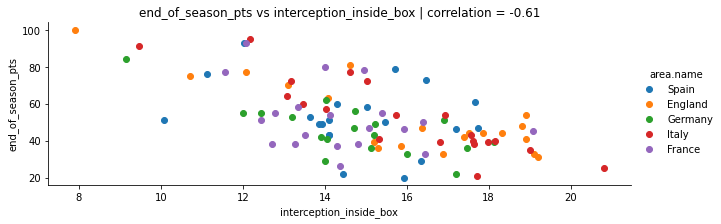

,sliding_tackle_total,end_of_season_pts
sliding_tackle_total,1.000000,-0.307383
end_of_season_pts,-0.307383,1.000000


<Figure size 1080x360 with 0 Axes>

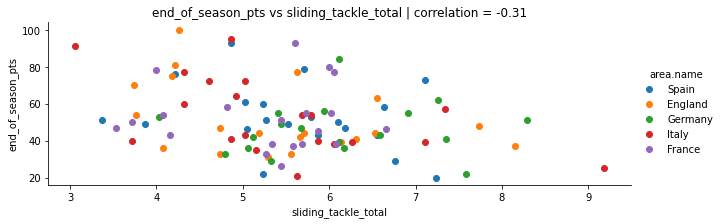

,sliding_tackle_inside_box,end_of_season_pts
sliding_tackle_inside_box,1.000000,-0.424783
end_of_season_pts,-0.424783,1.000000


<Figure size 1080x360 with 0 Axes>

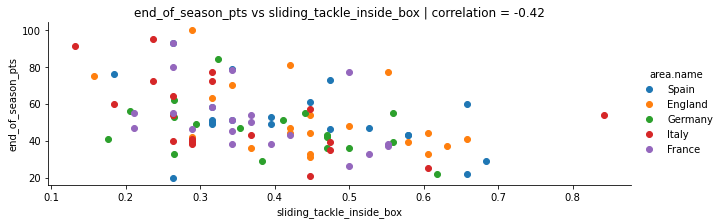

In [18]:
for metric in ['duels_lost',
               'duels_neutral',
               'duels_won',
               'yellow_card',
               'second_yellow_card',
               'total_fouls',
               'dangerous_ball_lost',
               'interception_total',
               'interception_inside_box',
               'sliding_tackle_total',
               'sliding_tackle_inside_box']:

    display(tmp[[metric, 'end_of_season_pts']].corr())

    plt.figure(figsize=(15, 5))
    fg = seaborn.FacetGrid(data=tmp, hue='area.name', hue_order=tmp['area.name'].unique(), aspect=3)
    fg.map(pyplot.scatter, metric, 'end_of_season_pts').add_legend()
    plt.title('end_of_season_pts vs {} | correlation = {}'.format(metric, tmp[[metric, 'end_of_season_pts']].corr().to_numpy()[0][1].round(2)))
    #plt.text(.3, 0.5,'$\\rho$=0.52', fontsize=18)
    plt.savefig('../figures/defense_metrics/counts_unnormalised/{}'.format(metric), bbox_inches='tight')
    plt.show()

#### Analysis : What if we normalize by possession? Still looking at EOS points

,duels_lost,end_of_season_pts
duels_lost,1.000000,-0.711653
end_of_season_pts,-0.711653,1.000000


<Figure size 1080x360 with 0 Axes>

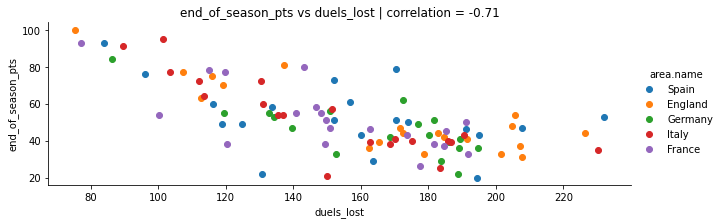

,duels_neutral,end_of_season_pts
duels_neutral,1.000000,-0.676237
end_of_season_pts,-0.676237,1.000000


<Figure size 1080x360 with 0 Axes>

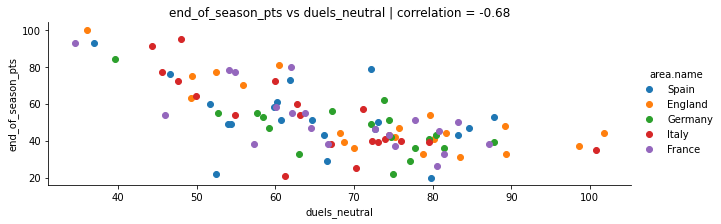

,duels_won,end_of_season_pts
duels_won,1.000000,-0.674621
end_of_season_pts,-0.674621,1.000000


<Figure size 1080x360 with 0 Axes>

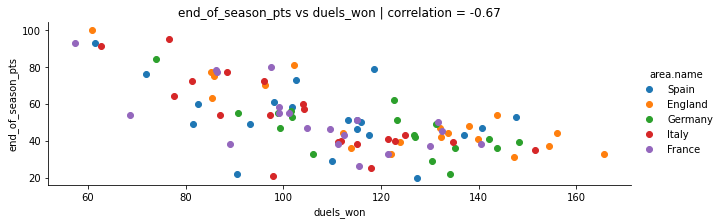

,yellow_card,end_of_season_pts
yellow_card,1.000000,-0.433223
end_of_season_pts,-0.433223,1.000000


<Figure size 1080x360 with 0 Axes>

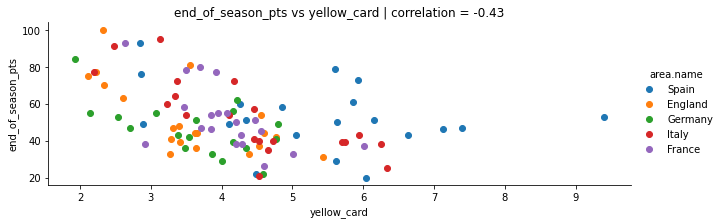

,second_yellow_card,end_of_season_pts
second_yellow_card,1.000000,-0.155385
end_of_season_pts,-0.155385,1.000000


<Figure size 1080x360 with 0 Axes>

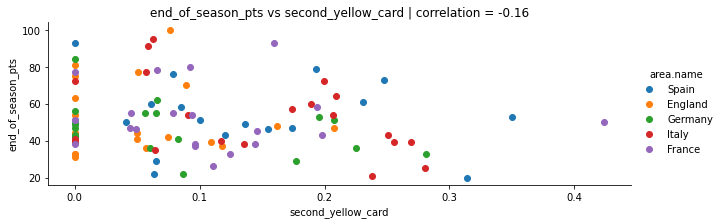

,total_fouls,end_of_season_pts
total_fouls,1.000000,-0.578416
end_of_season_pts,-0.578416,1.000000


<Figure size 1080x360 with 0 Axes>

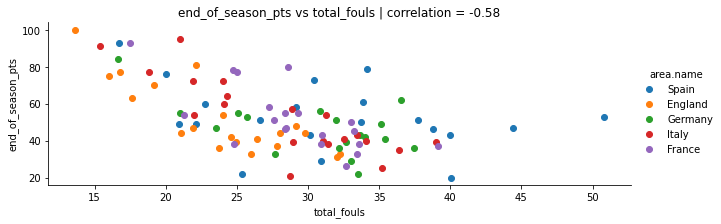

,dangerous_ball_lost,end_of_season_pts
dangerous_ball_lost,1.000000,-0.331745
end_of_season_pts,-0.331745,1.000000


<Figure size 1080x360 with 0 Axes>

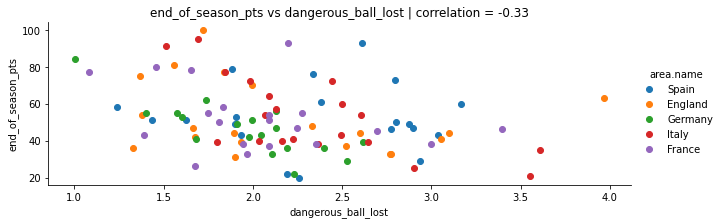

,interception_total,end_of_season_pts
interception_total,1.000000,-0.667761
end_of_season_pts,-0.667761,1.000000


<Figure size 1080x360 with 0 Axes>

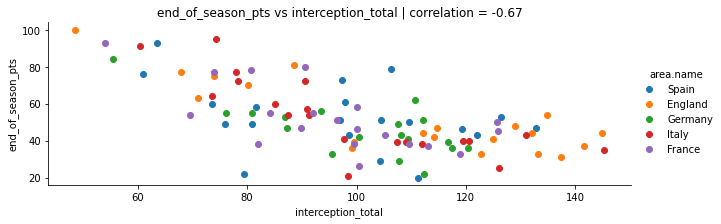

,interception_inside_box,end_of_season_pts
interception_inside_box,1.000000,-0.669192
end_of_season_pts,-0.669192,1.000000


<Figure size 1080x360 with 0 Axes>

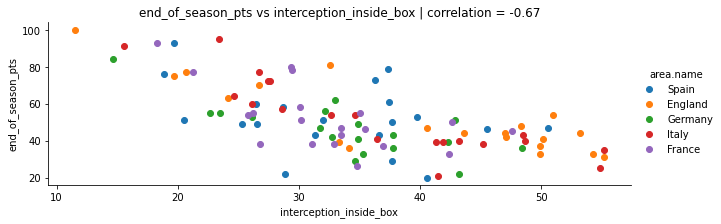

,sliding_tackle_total,end_of_season_pts
sliding_tackle_total,1.000000,-0.557668
end_of_season_pts,-0.557668,1.000000


<Figure size 1080x360 with 0 Axes>

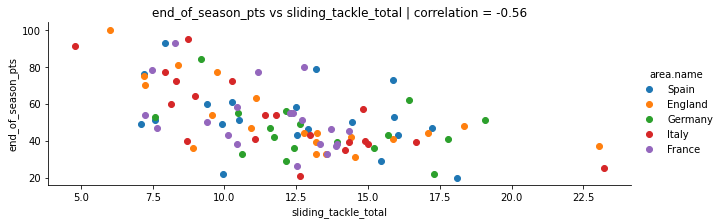

,sliding_tackle_inside_box,end_of_season_pts
sliding_tackle_inside_box,1.000000,-0.559455
end_of_season_pts,-0.559455,1.000000


<Figure size 1080x360 with 0 Axes>

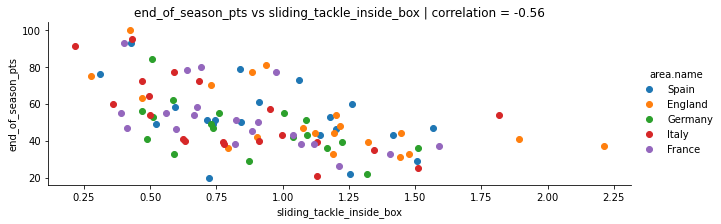

In [36]:
atts = [c for c in tmp.columns if c!='possession' and c not in performance.columns]

master_norm = master.copy()
master_norm[atts] = master_norm[atts].div(master_norm['possession'], axis=0)

tmp = pd.concat([master_norm.mean(level=1), performance], axis=1)

for metric in ['duels_lost',
               'duels_neutral',
               'duels_won',
               'yellow_card',
               'second_yellow_card',
               'total_fouls',
               'dangerous_ball_lost',
               'interception_total',
               'interception_inside_box',
               'sliding_tackle_total',
               'sliding_tackle_inside_box']:

    display(tmp[[metric, 'end_of_season_pts']].corr())

    plt.figure(figsize=(15, 5))
    fg = seaborn.FacetGrid(data=tmp, hue='area.name', hue_order=tmp['area.name'].unique(), aspect=3)
    fg.map(pyplot.scatter, metric, 'end_of_season_pts').add_legend()
    plt.title('end_of_season_pts vs {} | correlation = {}'.format(metric, tmp[[metric, 'end_of_season_pts']].corr().to_numpy()[0][1].round(2)))
    #plt.text(.3, 0.5,'$\\rho$=0.52', fontsize=18)
    plt.savefig('../figures/defense_metrics/counts_normalized/{}'.format(metric), bbox_inches='tight')
    plt.show()


In [37]:
master_norm

possession  duels_lost  duels_neutral   duels_won  \
matchId teamId                                                      
2499719 1609      0.724880   93.808581      60.699670   85.531353   
        1631      0.275120  341.669565     159.930435  192.643478   
2499720 1625      0.803838   60.957560      29.856764   52.249337   
        1651      0.196162  356.847826     122.347826  193.717391   
2499721 1610      0.635468  113.302326      28.325581   84.976744   
...                    ...         ...            ...         ...   
2576336 3315      0.402628  183.792285      79.477745  106.798220   
2576337 3164      0.551298  112.461883      38.091928   79.811659   
        3204      0.448702  171.606061      57.944904  109.203857   
2576338 3185      0.388506  187.899408      79.792899  128.698225   
        3193      0.611494   99.755639      47.424812   73.590226   

                yellow_card  second_yellow_card  total_fouls  \
matchId teamId                                                 
2499719 1609       0.000000            0.000000    12.415842   
        1631       3.634783            0.000000    43.617391   
2499720 1625       2.488064            0.000000    11.196286   
        1651       0.000000            0.000000    30.586957   
2499721 1610       6.294574            1.573643    28.325581   
...                     ...                 ...          ...   
2576336 3315       2.483680            0.000000    34.771513   
2576337 3164       5.441704            1.813901    23.580717   
        3204       2.228650            0.000000    22.286501   
2576338 3185       5.147929            2.573964    28.313609   
        3193       1.635338            0.000000    16.353383   

                dangerous_ball_lost  interception_total  \
matchId teamId                                            
2499719 1609               5.518152           55.181518   
        1631              14.539130          203.547826   
2499720 1625               1.244032           37.320955   
        1651              15.293478          275.282609   
2499721 1610               0.000000           42.488372   
...                             ...                 ...   
2576336 3315               4.967359          109.281899   
2576337 3164               0.000000           38.091928   
        3204               0.000000           78.002755   
2576338 3185               7.721893          105.532544   
        3193               1.635338           34.342105   

                interception_inside_box  sliding_tackle_total  \
matchId teamId                                                  
2499719 1609                   9.656766              2.759076   
        1631                  83.600000             25.443478   
2499720 1625                   3.732095              3.732095   
        1651                 112.152174             25.489130   
2499721 1610                   7.868217             15.736434   
...                                 ...                   ...   
2576336 3315                  52.157270             14.902077   
2576337 3164                  16.325112              3.627803   
        3204                  22.286501             15.600551   
2576338 3185                  38.609467             12.869822   
        3193                   6.541353              6.541353   

                sliding_tackle_inside_box  
matchId teamId                             
2499719 1609                     0.000000  
        1631                     0.000000  
2499720 1625                     0.000000  
        1651                     5.097826  
2499721 1610                     0.000000  
...                                   ...  
2576336 3315                     0.000000  
2576337 3164                     0.000000  
        3204                     0.000000  
2576338 3185                     2.573964  
        3193                     0.000000  

[3652 rows x 12 columns]

### Remark

Normalizing by possession typically gives a similar relationship with a much stronger correlation. It should thus be used for all the metrics in the final classification

## To-do
Look at:  
1) Fraction of slide tackles in box  
2) Fraction of interceptions in box  
3) Percentage of cards(yellow, second yellow, red) vs total_fouls. How many of these fouls were actually stategic?  
4) Does normalizing by possession help?

,fraction_slide_tackles_in_box,end_of_season_pts
fraction_slide_tackles_in_box,1.000000,-0.251152
end_of_season_pts,-0.251152,1.000000


<Figure size 1080x360 with 0 Axes>

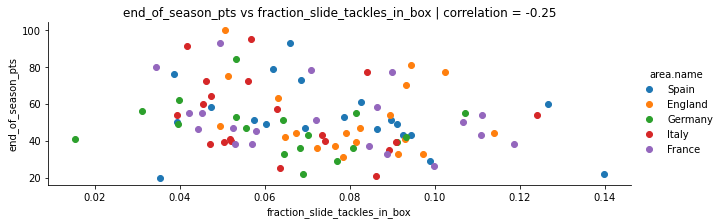

,fraction_interception_in_box,end_of_season_pts
fraction_interception_in_box,1.0000,-0.4823
end_of_season_pts,-0.4823,1.0000


<Figure size 1080x360 with 0 Axes>

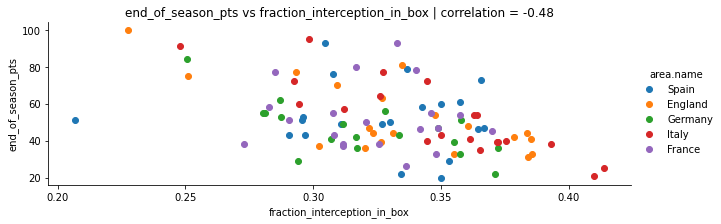

In [39]:
master_2 = pd.DataFrame(index=master.index)
master_2['fraction_slide_tackles_in_box'] = master['sliding_tackle_inside_box']/master['sliding_tackle_total']
master_2['fraction_interception_in_box'] = master['interception_inside_box']/master['interception_total']

tmp2 = pd.concat([master_2.mean(level=1), performance], axis=1)
#atts = [c for c in tmp2.columns if c!='possession' and c not in performance.columns]
#tmp2[atts] = tmp2[atts].div(tmp['possession'], axis=0)



for metric in ['fraction_slide_tackles_in_box',
               'fraction_interception_in_box']:

    display(tmp2[[metric, 'end_of_season_pts']].corr())

    plt.figure(figsize=(15, 5))
    fg = seaborn.FacetGrid(data=tmp2, hue='area.name', hue_order=tmp2['area.name'].unique(), aspect=3)
    fg.map(pyplot.scatter, metric, 'end_of_season_pts').add_legend()
    plt.title('end_of_season_pts vs {} | correlation = {}'.format(metric, tmp2[[metric, 'end_of_season_pts']].corr().to_numpy()[0][1].round(2)))
    #plt.text(.3, 0.5,'$\\rho$=0.52', fontsize=18)
    plt.savefig('../figures/defense_metrics/interceptions_slidetackles_box/{}'.format(metric), bbox_inches='tight')
    plt.show()

### Remark
Generally, the more the percentage of tackles/interceptions in the box, the worse your macroaveraged performance is. Does this pattern continue? Lets analyze the x coordinate of any slide tackle/interception, find centroid in a match, and analyze against points


,pos_x,end_of_season_pts
pos_x,1.000000,0.640682
end_of_season_pts,0.640682,1.000000


<Figure size 1080x360 with 0 Axes>

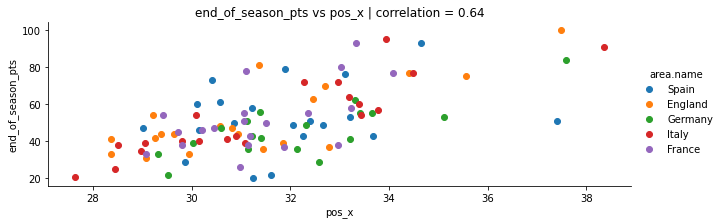

,pos_y,end_of_season_pts
pos_y,1.000000,-0.058958
end_of_season_pts,-0.058958,1.000000


<Figure size 1080x360 with 0 Axes>

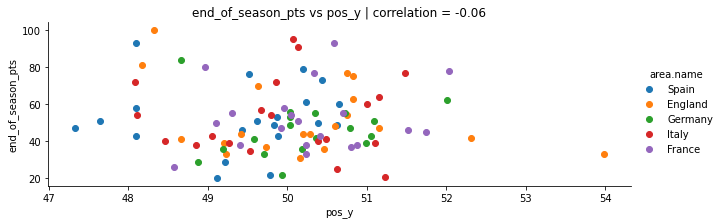

In [46]:
events3 = events.copy()
events3['tags'] = events3['tags'].apply(lambda l: [x['id'] for x in l])

events3 = events3.loc[np.array([True if 1601 in x or 1401 in x else False for x in events3['tags']])] #slide tackles/interception
events3['pos_x'], events3['pos_y'] = [coord[0]['x'] for coord in events3['positions']], [coord[0]['y'] for coord in events3['positions']]
events3 = events3[['matchId', 'teamId', 'tags', 'pos_x', 'pos_y']]
events3 = events3.groupby(by=['matchId', 'teamId'])[['pos_x', 'pos_y']].mean()
master_3 = events3[['pos_x', 'pos_y']].copy()

tmp = pd.concat([events3.mean(level=1), performance], axis=1)

for metric in ['pos_x', 'pos_y']:

    display(tmp[[metric, 'end_of_season_pts']].corr())

    plt.figure(figsize=(15, 5))
    fg = seaborn.FacetGrid(data=tmp, hue='area.name', hue_order=tmp['area.name'].unique(), aspect=3)
    fg.map(pyplot.scatter, metric, 'end_of_season_pts').add_legend()
    plt.title('end_of_season_pts vs {} | correlation = {}'.format(metric, tmp[[metric, 'end_of_season_pts']].corr().to_numpy()[0][1].round(2)))
    #plt.text(.3, 0.5,'$\\rho$=0.52', fontsize=18)
    plt.savefig('../figures/defense_metrics/interceptions_slidetackles_avg_coords/{}'.format(metric), bbox_inches='tight')
    plt.show()

### Remark
As expected, slide tackles/interceptions further away from the goal are better. The y direction doesn't tell us much, also expected.

## Fouls
Now lets look at fouls. Is there a strategic way to foul? Is there an optimal distance w.r.t (x,y) directions for fouls? What about the proportions of fouls (not)resulting in penalizing cards.

,fouls_committed,end_of_season_pts
fouls_committed,1.000000,-0.342855
end_of_season_pts,-0.342855,1.000000


<Figure size 1080x360 with 0 Axes>

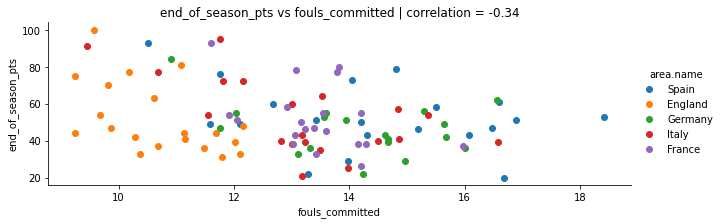

In [49]:
events4 = events.copy()
events4 = events4.loc[events4.eventName=='Foul']
events4 = events4.groupby(by=['matchId', 'teamId'])[['id']].count()
events4.columns = ['fouls_committed']
master_4 = events4.copy()
tmp = pd.concat([events4.mean(level=1), performance], axis=1)

for metric in ['fouls_committed']:

    display(tmp[[metric, 'end_of_season_pts']].corr())

    plt.figure(figsize=(15, 5))
    fg = seaborn.FacetGrid(data=tmp, hue='area.name', hue_order=tmp['area.name'].unique(), aspect=3)
    fg.map(pyplot.scatter, metric, 'end_of_season_pts').add_legend()
    plt.title('end_of_season_pts vs {} | correlation = {}'.format(metric, tmp[[metric, 'end_of_season_pts']].corr().to_numpy()[0][1].round(2)))
    #plt.text(.3, 0.5,'$\\rho$=0.52', fontsize=18)
    plt.savefig('../figures/defense_metrics/fouls/{}'.format(metric), bbox_inches='tight')
    plt.show()


,yellow_card_per_foul_committed,end_of_season_pts
yellow_card_per_foul_committed,1.000000,-0.013161
end_of_season_pts,-0.013161,1.000000


<Figure size 1080x360 with 0 Axes>

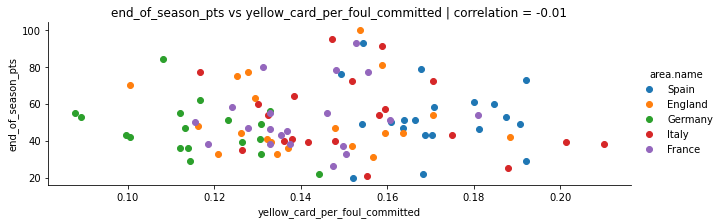

In [50]:
events4 = events.copy()
events4 = events4.loc[events4.eventName=='Foul']
events4['tags'] = events4['tags'].apply(lambda l: [x['id'] for x in l])
events4['yellow_card'] = events4['tags'].apply(lambda l: 1 if 1702 in l else 0)
events4 = events4.groupby(by=['matchId', 'teamId'])[['yellow_card']].sum() / events4.groupby(by=['matchId', 'teamId'])[['yellow_card']].count()
events4.columns = ['yellow_card_per_foul_committed']
master_5 = events4.copy()
tmp = pd.concat([events4.mean(level=1), performance], axis=1)

for metric in ['yellow_card_per_foul_committed']:

    display(tmp[[metric, 'end_of_season_pts']].corr())

    plt.figure(figsize=(15, 5))
    fg = seaborn.FacetGrid(data=tmp, hue='area.name', hue_order=tmp['area.name'].unique(), aspect=3)
    fg.map(pyplot.scatter, metric, 'end_of_season_pts').add_legend()
    plt.title('end_of_season_pts vs {} | correlation = {}'.format(metric, tmp[[metric, 'end_of_season_pts']].corr().to_numpy()[0][1].round(2)))
    #plt.text(.3, 0.5,'$\\rho$=0.52', fontsize=18)
    plt.savefig('../figures/defense_metrics/fouls/{}'.format(metric), bbox_inches='tight')
    plt.show()

### Remarks
Commiting fouls gives us a negative correlation but this is not because of bookings. See that the number of yellow cards per foul committed is an incredibly weak signal. Thus the performance degradation that comes with fouls is likely to have come from set pieces rarther than bookings

## Combining Everything & Saving

In [79]:
master_3 = master_3.rename({'pos_x':'centroid_slidetackles_interceptions_x',
                'pos_y':'centroid_slidetackles_interceptions_y'}, axis=1)
master_norm = master_norm.rename({c: c+'/possession' for c in master_norm.columns if c != 'possession'}, axis=1)

In [82]:
df = pd.concat([master,
                master_2,
                master_3,
                master_4,
                master_5], axis=1)
df.to_pickle(os.path.join(ROOT, 'intermediates', 'defensive_metrics_unnormalized.pkl.gz'))
df.to_csv(os.path.join(ROOT, 'intermediates', 'defensive_metrics_unnormalized.csv'))
df

possession  duels_lost  duels_neutral  duels_won  yellow_card  \
matchId teamId                                                                  
2499719 1609      0.724880          68             44         62            0   
        1631      0.275120          94             44         53            1   
2499720 1625      0.803838          49             24         42            2   
        1651      0.196162          70             24         38            0   
2499721 1610      0.635468          72             18         54            4   
...                    ...         ...            ...        ...          ...   
2576336 3315      0.402628          74             32         43            1   
2576337 3164      0.551298          62             21         44            3   
        3204      0.448702          77             26         49            1   
2576338 3185      0.388506          73             31         50            2   
        3193      0.611494          61             29         45            1   

                second_yellow_card  total_fouls  dangerous_ball_lost  \
matchId teamId                                                         
2499719 1609                     0            9                    4   
        1631                     0           12                    4   
2499720 1625                     0            9                    1   
        1651                     0            6                    3   
2499721 1610                     1           18                    0   
...                            ...          ...                  ...   
2576336 3315                     0           14                    2   
2576337 3164                     1           13                    0   
        3204                     0           10                    0   
2576338 3185                     1           11                    3   
        3193                     0           10                    1   

                interception_total  interception_inside_box  \
matchId teamId                                                
2499719 1609                    40                        7   
        1631                    56                       23   
2499720 1625                    30                        3   
        1651                    54                       22   
2499721 1610                    27                        5   
...                            ...                      ...   
2576336 3315                    44                       21   
2576337 3164                    21                        9   
        3204                    35                       10   
2576338 3185                    41                       15   
        3193                    21                        4   

                sliding_tackle_total  sliding_tackle_inside_box  \
matchId teamId                                                    
2499719 1609                       2                          0   
        1631                       7                          0   
2499720 1625                       3                          0   
        1651                       5                          1   
2499721 1610                      10                          0   
...                              ...                        ...   
2576336 3315                       6                          0   
2576337 3164                       2                          0   
        3204                       7                          0   
2576338 3185                       5                          1   
        3193                       4                          0   

                fraction_slide_tackles_in_box  fraction_interception_in_box  \
matchId teamId                                                                
2499719 1609                              0.0                      0.175000   
        1631                              0.0                      0.410714   
2499720 1625     

In [83]:
df = pd.concat([master_norm,
                master_2,
                master_3,
                master_4,
                master_5], axis=1)
df.to_pickle(os.path.join(ROOT, 'intermediates', 'defensive_metrics_normalized_by_possession.pkl.gz'))
df.to_csv(os.path.join(ROOT, 'intermediates', 'defensive_metrics_normalized_by_possession.csv'))
df

possession  duels_lost/possession  duels_neutral/possession  \
matchId teamId                                                                
2499719 1609      0.724880              93.808581                 60.699670   
        1631      0.275120             341.669565                159.930435   
2499720 1625      0.803838              60.957560                 29.856764   
        1651      0.196162             356.847826                122.347826   
2499721 1610      0.635468             113.302326                 28.325581   
...                    ...                    ...                       ...   
2576336 3315      0.402628             183.792285                 79.477745   
2576337 3164      0.551298             112.461883                 38.091928   
        3204      0.448702             171.606061                 57.944904   
2576338 3185      0.388506             187.899408                 79.792899   
        3193      0.611494              99.755639                 47.424812   

                duels_won/possession  yellow_card/possession  \
matchId teamId                                                 
2499719 1609               85.531353                0.000000   
        1631              192.643478                3.634783   
2499720 1625               52.249337                2.488064   
        1651              193.717391                0.000000   
2499721 1610               84.976744                6.294574   
...                              ...                     ...   
2576336 3315              106.798220                2.483680   
2576337 3164               79.811659                5.441704   
        3204              109.203857                2.228650   
2576338 3185              128.698225                5.147929   
        3193               73.590226                1.635338   

                second_yellow_card/possession  total_fouls/possession  \
matchId teamId                                                          
2499719 1609                         0.000000               12.415842   
        1631                         0.000000               43.617391   
2499720 1625                         0.000000               11.196286   
        1651                         0.000000               30.586957   
2499721 1610                         1.573643               28.325581   
...                                       ...                     ...   
2576336 3315                         0.000000               34.771513   
2576337 3164                         1.813901               23.580717   
        3204                         0.000000               22.286501   
2576338 3185                         2.573964               28.313609   
        3193                         0.000000               16.353383   

                dangerous_ball_lost/possession  interception_total/possession  \
matchId teamId                                                                  
2499719 1609                          5.518152                      55.181518   
        1631                         14.539130                     203.547826   
2499720 1625                          1.244032                      37.320955   
        1651                         15.293478                     275.282609   
2499721 1610                          0.000000                      42.488372   
...                                        ...                            ...   
2576336 3315                          4.967359                     109.281899   
2576337 3164                          0.000000                      38.091928   
        3204                          0.000000                      78.002755   
2576338 3185                          7.721893                     105.532544   
        3193                          1.635338                      34.342105   

                interception_inside_box/possession  \
matchId teamId                                       
2499719 1609                              9